# Ic Prediction Model Evaluation

This notebook evaluates the fine-tuned model's performance on predicting the Soil Behavior Type Index (Ic) 
from CPT measurements. We'll test on the held-out test set and visualize the results.


In [1]:
import os
import yaml
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats


In [2]:
# Change working directory to project root
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

# Add src to path
import sys
sys.path.append(os.path.abspath('src'))

from model import CPTFoundationModel, IcPredictionModel
from finetune import CPTFineTuneDataset, collate_finetune

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
print(f"Using random seed: {SEED}")

Using random seed: 42


## 1. Load Configuration and Models

In [3]:
# Load fine-tuning configuration
config_path = 'configs/PG_finetune_Ic.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Load foundation model configuration
foundation_config_path = 'configs/PG_dataset.yaml'
with open(foundation_config_path, 'r') as f:
    foundation_config = yaml.safe_load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


 ## 2. Load the Fine-tuned Model

In [6]:
# Initialize foundation model
foundation_model_params = foundation_config['model_params']
foundation_model = CPTFoundationModel(
    num_features=foundation_model_params['num_features'],
    model_dim=foundation_model_params['model_dim'],
    num_heads=foundation_model_params['num_heads'],
    num_layers=foundation_model_params['num_layers']
)

# Create the fine-tuning model
model = IcPredictionModel(
    foundation_model=foundation_model,
    model_dim=foundation_model_params['model_dim']
).to(device)

# Load the fine-tuned weights
checkpoint_path = config['data_paths']['finetuned_model_save_path']
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Loaded fine-tuned model from: {checkpoint_path}")
    print(f"Trained for {checkpoint.get('epoch', 'unknown')} epochs")
    print(f"Best validation loss: {checkpoint.get('val_loss', 'N/A'):.6f}")
    print(f"Validation MAE: {checkpoint.get('val_mae', 'N/A'):.4f}")
    print(f"Validation RMSE: {checkpoint.get('val_rmse', 'N/A'):.4f}")
else:
    raise FileNotFoundError(f"Fine-tuned model not found at {checkpoint_path}")


Loaded fine-tuned model from: models/finetuned_ic_predictor.pth
Trained for 199 epochs
Best validation loss: 0.195153
Validation MAE: 0.2777
Validation RMSE: 0.4421


 ## 3. Load Test Data

In [7]:
# Load labels
labels_df = pd.read_csv(config['data_paths']['labels_file'])
print(f"Loaded {len(labels_df)} label entries")
print(f"\nIc statistics in dataset:")
print(f"  Mean: {labels_df['Ic'].mean():.2f}")
print(f"  Std: {labels_df['Ic'].std():.2f}")
print(f"  Min: {labels_df['Ic'].min():.2f}")
print(f"  Max: {labels_df['Ic'].max():.2f}")

# Load test IDs
test_ids = np.loadtxt('data/splits/test_ids.txt', dtype=int).tolist()
print(f"\nTest set contains {len(test_ids)} CPT profiles")

# Create test dataset
test_dataset = CPTFineTuneDataset(
    config['data_paths']['processed_dir'],
    labels_df,
    test_ids,
    max_len=512,
    overlap=128
)

# Create dataloader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=collate_finetune,
    num_workers=4
)

print(f"Test set has {len(test_dataset)} chunks")


Loaded 2516851 label entries

Ic statistics in dataset:
  Mean: 2.48
  Std: 0.81
  Min: 0.00
  Max: 4.06

Test set contains 135 CPT profiles
Loading 135 CPT profiles for fine-tuning...


Loading data: 100%|██████████| 135/135 [00:00<00:00, 647.20it/s]

Created 680 chunks for training
Test set has 680 chunks


 ## 4. Run Predictions on Test Set

In [8]:
# Run predictions
all_predictions = []
all_targets = []
all_masks = []

model.eval()
with torch.no_grad():
    for features, labels, attention_mask in tqdm(test_loader, desc="Running predictions"):
        features = features.to(device)
        labels = labels.to(device)
        attention_mask = attention_mask.to(device)
        
        # Get predictions
        predictions = model(features, attention_mask)
        
        # Store results for valid positions only
        valid_mask = (labels != -100) & (attention_mask == 1)
        
        if valid_mask.any():
            all_predictions.extend(predictions[valid_mask].cpu().numpy())
            all_targets.extend(labels[valid_mask].cpu().numpy())
            all_masks.extend(valid_mask.cpu().numpy())

# Convert to arrays
predictions_np = np.array(all_predictions)
targets_np = np.array(all_targets)

print(f"Total predictions: {len(predictions_np)}")


Running predictions:   0%|          | 0/43 [00:00<?, ?it/s]/home/griff/miniconda3/envs/cpt-fm/lib/python3.10/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
Running predictions: 100%|██████████| 43/43 [00:00<00:00, 44.32it/s]

Total predictions: 326564


 ## 5. Calculate Metrics

In [9]:
# Calculate metrics
mse = mean_squared_error(targets_np, predictions_np)
rmse = np.sqrt(mse)
mae = mean_absolute_error(targets_np, predictions_np)
r2 = r2_score(targets_np, predictions_np)

# Calculate percentile errors
errors = np.abs(predictions_np - targets_np)
p50 = np.percentile(errors, 50)
p90 = np.percentile(errors, 90)
p95 = np.percentile(errors, 95)

print("Test Set Performance Metrics:")
print("="*40)
print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"\nError Percentiles:")
print(f"50th percentile (median): {p50:.4f}")
print(f"90th percentile: {p90:.4f}")
print(f"95th percentile: {p95:.4f}")


Test Set Performance Metrics:
MSE:  0.201832
RMSE: 0.4493
MAE:  0.2776
R²:   0.6757

Error Percentiles:
50th percentile (median): 0.1822
90th percentile: 0.5634
95th percentile: 0.7471


 ## 6. Visualization: Scatter Plot

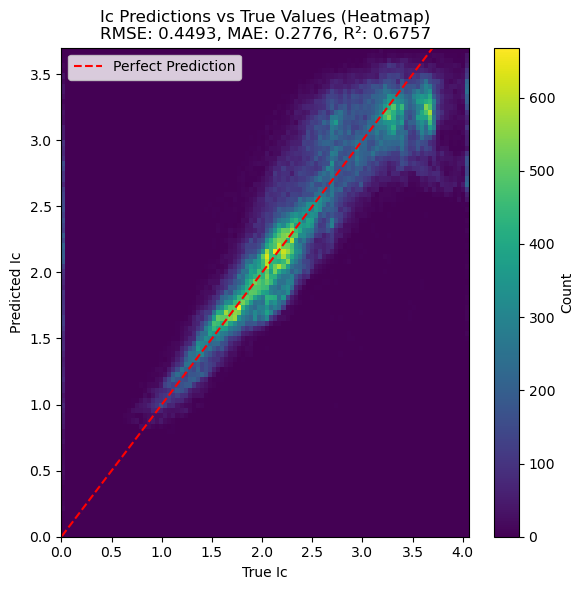

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# 2D histogram (heatmap) of predictions vs targets
hb = plt.hist2d(targets_np, predictions_np, bins=100, cmap='viridis')
plt.colorbar(hb[3], label='Count')

# Perfect prediction line
min_val = min(targets_np.min(), predictions_np.min())
max_val = max(targets_np.max(), predictions_np.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')

plt.title(f'Ic Predictions vs True Values (Heatmap)\nRMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')
plt.xlabel('True Ic')
plt.ylabel('Predicted Ic')
plt.legend()
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()


 ## 7. Error Distribution

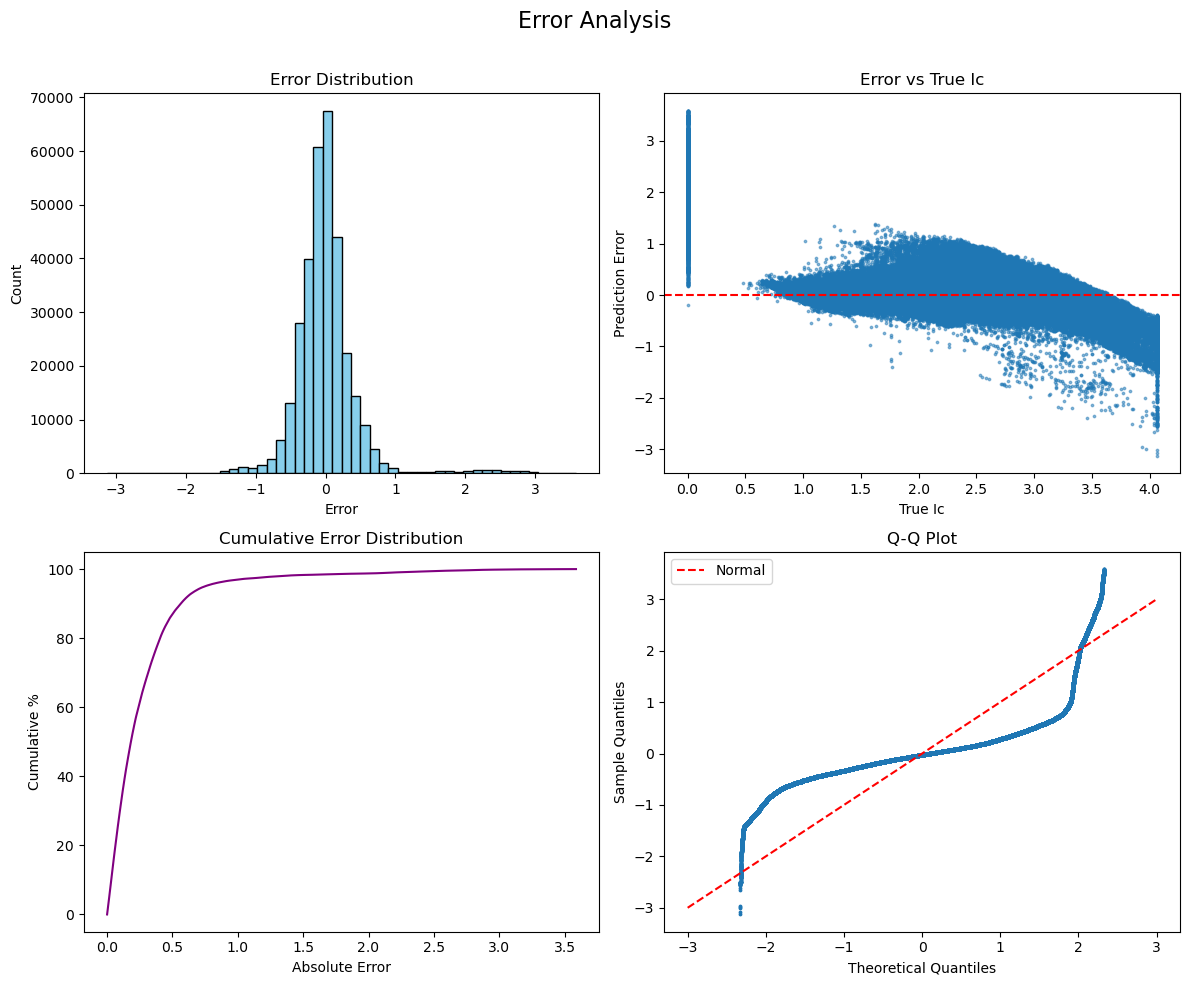

In [11]:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Error Analysis", fontsize=16)

# 1. Histogram of errors
signed_errors = predictions_np - targets_np
axs[0, 0].hist(signed_errors, bins=50, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Error Distribution')
axs[0, 0].set_xlabel('Error')
axs[0, 0].set_ylabel('Count')

# 2. Error vs True Value
axs[0, 1].scatter(targets_np, signed_errors, s=3, alpha=0.5)
axs[0, 1].axhline(0, color='red', linestyle='--')
axs[0, 1].set_title('Error vs True Ic')
axs[0, 1].set_xlabel('True Ic')
axs[0, 1].set_ylabel('Prediction Error')

# 3. Cumulative distribution
sorted_errors = np.sort(np.abs(signed_errors))
cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
axs[1, 0].plot(sorted_errors, cumulative * 100, color='purple')
axs[1, 0].set_title('Cumulative Error Distribution')
axs[1, 0].set_xlabel('Absolute Error')
axs[1, 0].set_ylabel('Cumulative %')

# 4. Q-Q plot
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(signed_errors)))
sample_quantiles = np.sort(signed_errors)
axs[1, 1].scatter(theoretical_quantiles, sample_quantiles, s=3)
axs[1, 1].plot([-3, 3], [-3, 3], 'r--', label='Normal')
axs[1, 1].set_title('Q-Q Plot')
axs[1, 1].set_xlabel('Theoretical Quantiles')
axs[1, 1].set_ylabel('Sample Quantiles')
axs[1, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


 ## 8. Example CPT Profile Predictions

In [17]:
# Load scaler for inverse transformation
scaler_path = foundation_config['data_paths']['scaler_path']
if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
else:
    scaler = None
    print("Warning: Scaler not found, will show scaled values")

# Select a random test CPT for detailed visualization
example_cpt_id = np.random.choice(test_ids)
print(f"Visualizing CPT ID: {example_cpt_id}")

# Load the features and labels for this CPT
feature_path = os.path.join(config['data_paths']['processed_dir'], f"cpt_{example_cpt_id}.pt")
features = torch.load(feature_path)
cpt_labels = labels_df[labels_df['ID'] == example_cpt_id].sort_values('Depth')

# Ensure alignment
min_len = min(len(features), len(cpt_labels))
features = features[:min_len]
true_ic = cpt_labels['Ic'].values[:min_len]
depths = cpt_labels['Depth'].values[:min_len]

# Get predictions for this CPT
features_batch = features.unsqueeze(0).to(device)
attention_mask = torch.ones(1, len(features)).to(device)

with torch.no_grad():
    predicted_ic = model(features_batch, attention_mask).squeeze(0).cpu().numpy()

# Inverse transform features if scaler available
if scaler and features.shape[1] >= 2:
    features_unscaled = scaler.inverse_transform(features[:, :2].numpy())
else:
    features_unscaled = features[:, :2].numpy()

# Create visualization
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('qc (kPa)', 'fs (kPa)', 'Ic (Soil Behavior Type Index)'),
    shared_yaxes=True
)

# Plot qc
fig.add_trace(
    go.Scatter(x=features_unscaled[:, 0], y=depths, mode='lines',
               name='qc', line=dict(color='blue')),
    row=1, col=1
)

# Plot fs
fig.add_trace(
    go.Scatter(x=features_unscaled[:, 1], y=depths, mode='lines',
               name='fs', line=dict(color='green')),
    row=1, col=2
)

# Plot Ic - both true and predicted
fig.add_trace(
    go.Scatter(x=true_ic, y=depths, mode='lines',
               name='True Ic', line=dict(color='blue', width=2)),
    row=1, col=3
)
fig.add_trace(
    go.Scatter(x=predicted_ic, y=depths, mode='lines',
               name='Predicted Ic', line=dict(color='red', dash='dash', width=2)),
    row=1, col=3
)

# Update layout
fig.update_yaxes(autorange="reversed", title_text="Depth (m)", row=1, col=1)
fig.update_xaxes(title_text="qc (kPa)", row=1, col=1)
fig.update_xaxes(title_text="fs (kPa)", row=1, col=2)
fig.update_xaxes(title_text="Ic", row=1, col=3)

# Add Ic zones as background
ic_zones = [
    (1.31, 2.05, "Sensitive fine-grained", "rgba(255,0,0,0.1)"),
    (2.05, 2.60, "Organic soils - clay", "rgba(255,165,0,0.1)"),
    (2.60, 2.95, "Clay - silty clay", "rgba(255,255,0,0.1)"),
    (2.95, 3.60, "Silt mixtures", "rgba(0,255,0,0.1)"),
    (3.60, 4.00, "Sand mixtures", "rgba(0,0,255,0.1)"),
]

for ic_min, ic_max, label, color in ic_zones:
    fig.add_vrect(
        x0=ic_min, x1=ic_max,
        fillcolor=color, layer="below",
        line_width=0,
        annotation_text=label,
        annotation_position="top left",
        annotation_textangle=-90,
        row=1, col=3
    )

fig.update_layout(
    title=f'CPT Profile {example_cpt_id}: Input Features and Ic Predictions',
    height=800,
    width=1400,
    showlegend=True
)

fig.show()

# Calculate metrics for this specific CPT
cpt_mae = np.mean(np.abs(predicted_ic - true_ic))
cpt_rmse = np.sqrt(np.mean((predicted_ic - true_ic) ** 2))
print(f"\nMetrics for CPT {example_cpt_id}:")
print(f"  MAE: {cpt_mae:.4f}")
print(f"  RMSE: {cpt_rmse:.4f}")

Visualizing CPT ID: 1082



Metrics for CPT 1082:
  MAE: 0.2410
  RMSE: 0.3803


 ## 9. Performance by Ic Range


Performance by Ic Range (Soil Type):
 Ic Range               Soil Type  Count      MAE     RMSE           R²
0.00-1.31 Very stiff fine-grained  19232 0.777771 1.281629    -4.461462
1.31-2.05  Sensitive fine-grained  80437 0.148062 0.202368     0.016495
2.05-2.60    Organic soils - clay  94044 0.232580 0.304146    -2.905652
2.60-2.95       Clay - silty clay  41582 0.271755 0.331426   -10.236319
2.95-3.60           Silt mixtures  66184 0.234580 0.301017    -1.761519
3.60-4.00           Sand mixtures  21286 0.530784 0.591679   -42.404427
4.00-5.00   Gravelly sand to sand   3799 0.993624 1.065251 -4566.999512


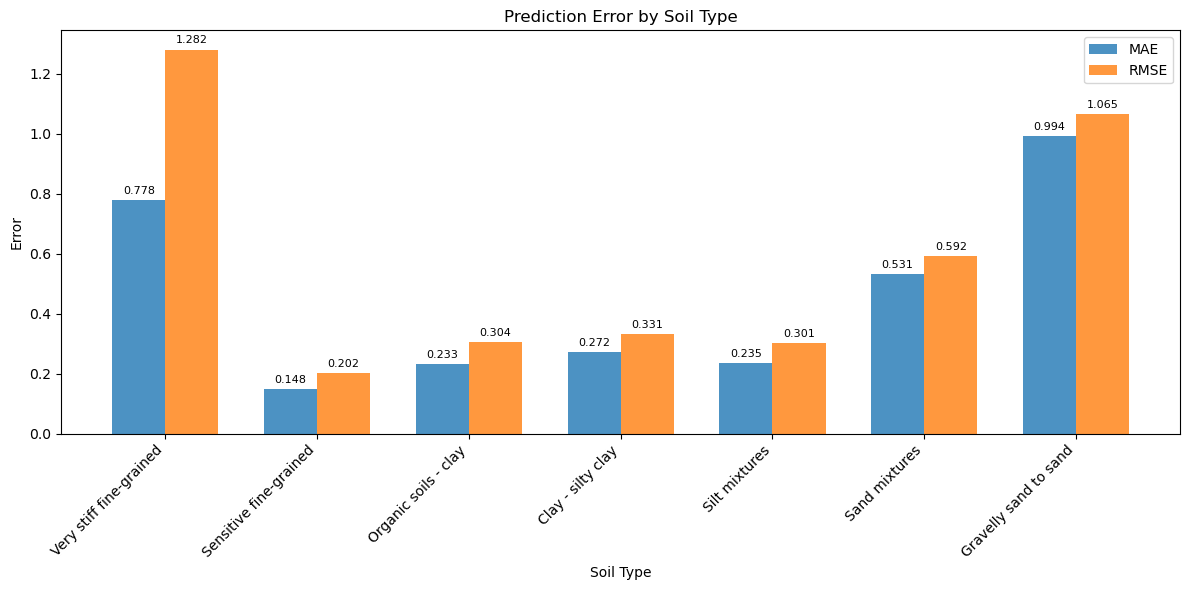

In [13]:
# Analyze performance by Ic ranges (soil type categories)
ic_ranges = [
    (0, 1.31, "Very stiff fine-grained"),
    (1.31, 2.05, "Sensitive fine-grained"),
    (2.05, 2.60, "Organic soils - clay"),
    (2.60, 2.95, "Clay - silty clay"),
    (2.95, 3.60, "Silt mixtures"),
    (3.60, 4.00, "Sand mixtures"),
    (4.00, 5.00, "Gravelly sand to sand"),
]

range_metrics = []
for ic_min, ic_max, soil_type in ic_ranges:
    mask = (targets_np >= ic_min) & (targets_np < ic_max)
    if mask.sum() > 0:
        range_preds = predictions_np[mask]
        range_targets = targets_np[mask]
        
        range_mae = mean_absolute_error(range_targets, range_preds)
        range_rmse = np.sqrt(mean_squared_error(range_targets, range_preds))
        range_r2 = r2_score(range_targets, range_preds) if len(range_targets) > 1 else 0
        
        range_metrics.append({
            'Ic Range': f"{ic_min:.2f}-{ic_max:.2f}",
            'Soil Type': soil_type,
            'Count': mask.sum(),
            'MAE': range_mae,
            'RMSE': range_rmse,
            'R²': range_r2
        })

metrics_df = pd.DataFrame(range_metrics)
print("\nPerformance by Ic Range (Soil Type):")
print(metrics_df.to_string(index=False))

# Visualize as bar chart using Matplotlib with rotated labels
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(metrics_df))
width = 0.35

bars1 = ax.bar(x - width/2, metrics_df['MAE'], width, label='MAE', alpha=0.8)
bars2 = ax.bar(x + width/2, metrics_df['RMSE'], width, label='RMSE', alpha=0.8)

ax.set_xlabel('Soil Type')
ax.set_ylabel('Error')
ax.set_title('Prediction Error by Soil Type')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Soil Type'], rotation=45, ha='right')
ax.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8)

plt.tight_layout()
plt.show()

 ## 10. Save Results

In [14]:
# Save predictions to CSV for further analysis
results_df = pd.DataFrame({
    'true_ic': targets_np,
    'predicted_ic': predictions_np,
    'absolute_error': np.abs(predictions_np - targets_np),
    'signed_error': predictions_np - targets_np
})

output_path = 'results/ic_predictions_test_set.csv'
os.makedirs('results', exist_ok=True)
results_df.to_csv(output_path, index=False)
print(f"\nPredictions saved to: {output_path}")

# Save summary metrics
summary = {
    'mse': float(mse),
    'rmse': float(rmse),
    'mae': float(mae),
    'r2': float(r2),
    'median_error': float(p50),
    'p90_error': float(p90),
    'p95_error': float(p95),
    'n_predictions': len(predictions_np)
}

import json
with open('results/ic_prediction_metrics.json', 'w') as f:
    json.dump(summary, f, indent=2)
print(f"Metrics saved to: results/ic_prediction_metrics.json")

print("\nEvaluation complete!")


Predictions saved to: results/ic_predictions_test_set.csv
Metrics saved to: results/ic_prediction_metrics.json

Evaluation complete!
